# Case Study 7

__Team Members:__ Amber Clark, Andrew Leppla, Jorge Olmos, Paritosh Rai

# Content
* [Business Understanding](#business-understanding)
    - [Introduction](#introduction)
    - [Methods](#methods)
    - [Results](#results)
* [Data Evaluation](#data-evaluation)
    - [Loading Data](#loading-data) 
    - [Data Summary](#data-summary)
    - [Missing Values](#missing-values)
    - [Exploratory Data Analysis (EDA)](#eda)
* [Model Preparations](#model-preparations)
    - [Sampling & Scaling Data](#sampling-scaling-data)
    - [Proposed Method](#proposed-metrics)
    - [Evaluation Metrics](#evaluation-metrics)
    - [Feature Selection](#feature-selection)
* [Model Building & Evaluations](#model-building)
    - [Performance Analysis](#performance-analysis)
* [Model Interpretability & Explainability](#model-explanation)
    - [Examining Feature Importance](#examining-feature-importance)
* [Conclusion](#conclusion)
    - [Final Model Proposal](#final-model-proposal)
    - [Future Considerations, Model Enhancements and Alternative Modeling Approaches](#model-enhancements)

# Business Understanding & Executive Summary <a id='business-understanding'/>

## Objective:

The objective of this case study is to classify a binary target in an anonymous dataset with the goal of reducing monetary losses as much as possible for the customer.


## Introduction:





## Modeling:

### Training and Test Split


### Key Metrics
       

### Model Building


### Results

   


## Conclusion



## Future Considerations


# Data Evaluation <a id='data-evaluation'>
    

Summarize the data being used in the case using appropriate mediums (charts, graphs, tables); address questions such as: Are there missing values? Which variables are needed (which ones are not)? What assumptions or conclusions are you drawing that need to be relayed to your audience?

## Loading Data <a id='loading-data'>

In [1]:
# standard libraries
import os
import pandas as pd
import numpy as np
#import re
import os
from IPython.display import Image
from abc import ABC, abstractmethod
import time
#import sklearn
#import time

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
from IPython.display import clear_output
import xgboost

# data pre-processing
from scipy.io import arff
#from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.impute._base import _BaseImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# prediction models
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm._base import BaseSVC 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

In [2]:
class FilePathManager:
    def __init__(self, local_dir: str):
        self.local_dir = local_dir
    
    def retrieve_full_path(self):
        return os.getcwd()+'/'+self.local_dir

In [3]:
class Loader:
    df = pd.DataFrame()
    
    def load_data(self, file_name):
        pass
    
    def get_df(self):
        pass
    
    def size(self):
        return len(self.df)

In [4]:
from typing import Callable
 
class CSVLoader(Loader):
    def __init__(self, file_path_manager: FilePathManager):
        self.file_path_manager = file_path_manager
        
    def load_data(self, _prepare_data: Callable[[pd.DataFrame], pd.DataFrame] = None):
        self.df = pd.read_csv(self.file_path_manager.retrieve_full_path())
        if _prepare_data:
            self.df = _prepare_data(self.df)
    
    def get_df(self):
        return self.df;
    
    def size(self):
        return len(self.df)  

In [5]:
def clean_data(df):
    df['y'] = df['y'].astype(int)
    df['x32'] = df['x32'].str.replace('%','').astype(float)
    df['x37'] = df['x37'].str.replace('$','').astype(float)
    return df

In [6]:
loader = CSVLoader(FilePathManager('final_project(5).csv'))
loader.load_data(clean_data)

## Data Summary <a id='data-summary'>
    
The dataset consists of fifty (50) features and a binary target class. There is no metadata or other descriptive information for the dataset, and the fifty feature labels are numbered from "x0" to "x49". There are 160,000 observations in the dataset; less than 0.03% of the features were missing data, and the imputation of these missing values is described below in the Missing Data section. Most of the features provided are numeric, but five were initially imported as text features.
    
Three of the five text features were identified as continents, months of the year, and days of the week. The values were cleaned up for spelling correction and consistency. The other two text object columns were numeric columns with a special character introduced in the data; column x32 had a trailing "%" and column x37 had a leading "$". These characters were removed so that these columns would be treated as numeric.
    



## Missing Values <a id='missing-values'>



All of the variables, except the target class, had missing values. The chart below depicts the number of observations missing values for each feature. Note: Even though the plot doesn't show missing values for categorical features, they do have missing values which are represented as nan's and so are missing from the plot.

<img src='https://raw.githubusercontent.com/olmosjorge28/QTW-SPRING-2022/main/ds7333_case_study_7/visuals/missing_values.png'></img>

The number of missing values was consistently around 20-40 missing observations for each column (less than 0.03% of 160,000 observations). For the logistic regression and neural network models, the mean of each column was used to impute the missing values for the numeric data, and the mode of each column was used for the missing categorical features.  For the XGBoost model, the algorithm can automatically handle missing values and find their optimal split for modeling, so no imputation was done prior to modeling. 

## Exploratory Data Analysis (EDA) <a id='eda'>



The numeric data was examined to view the scales of the variables, and the data needs normalization to be effectively used in most types of models without issues. 

For two model types, logistic regression and neural network, the categorical data for the three text columns were one-hot encoded to produce binary features for each of the values within those variables. In this data, there were three continents, twelve months, and five days of the week, so the one-hot encoding process did not contribute to creating an excess of sparsity in the dataframe that would be used for modeling. After one-hot encoding, the total number of explanatory features has increased to 67.
For the third model type, XGBoost, the categorical data were not one-hot encoded but rather label-encoded so the tree-based algorithm could split the data effectively.


### Balance of Target

The target classes are considered balanced in the dataset, with roughly 40:60 split between the positive and negative classes, as depicted below.

<img src='https://raw.githubusercontent.com/olmosjorge28/QTW-SPRING-2022/main/ds7333_case_study_7/visuals/y_dist.png'></img>

# Model Preparations <a id='model-preparations'/>

In [8]:
class BaseImputer:
    def fit(self, X, y=None):
        pass
    
    def transform(self, X):
        pass

class BaseModel:

    def fit(self, X, y, sample_weight=None):
        pass
    
    def predict(self, X):
        pass

In [9]:
class Modeling:
    _X_train_fitted = None
    _X_test_fitted = None
    _y_train = None
    _y_test = None
    _y_preds = None
    _y_preds_proba = None
    
    def __init__(self, data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, scaler = None, encoder = None):
        self._data = data
        self._target_name = target_name
        self._shuffle_splitter = shuffle_splitter
        self._imputer = imputer
        self._model = model
        self._encoder = encoder
        self._X, self._y = self._split_data()
        self._scaler = scaler
        
    @property
    def X(self):
        return self._X
    
    @property
    def y(self):
        return self._y

    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, model):
        self._model = model
     
    @property
    def X_train(self):
        return self._X_train_fitted
    
    @property
    def X_test(self):
        return self._X_test_fitted
    
    @property
    def y_train(self):
        return self._y_train
    
    @property
    def y_test(self):
        return self._y_test
    
    @property
    def y_preds(self):
        return self._y_preds
    
    def _split_data(self):
        X = self._data.copy()
        return X.drop([self._target_name], axis=1) , X[self._target_name]
    
    def _shuffle_split(self):
        X = self.X
        y = self.y
        for train_index, test_index in self._shuffle_splitter.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
    def _fit_imputer(self, train):
        if self._imputer is not None:
            self._imputer.fit(train)
    
    def _fit_scaler(self, train, cont_vars = None):
        transform_cols = None
        if cont_vars is None:
            transform_cols = self.X.columns
        else:
            transform_cols = cont_vars
            
        if self._scaler is not None:
            self._scaler.fit(train[transform_cols])
    
    def _impute_data(self, X: pd.DataFrame):
        if self._imputer is not None:
            return pd.DataFrame(self._imputer.transform(X), columns = self.X.columns, index = X.index)
        return X
    
    def _scale_data(self, X: pd.DataFrame, cont_vars = None):
        transform_cols = None
        if cont_vars is None:
            transform_cols = X.columns
        else:
            transform_cols = cont_vars
        scaled_data = X[transform_cols]
        if self._scaler is not None:
            scaled_data = pd.DataFrame(self._scaler.transform(X[transform_cols]), columns = transform_cols)
        X[transform_cols] = scaled_data
        return X
    
    def _encode_data(self):
        df = self.X.copy()
        cont_vars = df.describe().columns
        cat_vars = set(df.columns) - set(cont_vars)
        for column in [*cat_vars]:
            df[column] = self._encoder.fit_transform(df[column].astype(str))
        self._X = df
        return cont_vars, cat_vars
        
    
    def prepare(self):
        cont_vars = None
        if self._encoder is not None: 
            cont_vars, _ = self._encode_data()
        X_train, X_test, y_train, y_test = self._shuffle_split()   
        self._fit_imputer(X_train)
        X_train = self._impute_data(X_train)
        X_test = self._impute_data(X_test)
        self._fit_scaler(X_train, cont_vars)
        self._X_train_fitted = self._scale_data(X_train, cont_vars)
        self._X_test_fitted = self._scale_data(X_test, cont_vars)
        self._y_train = y_train
        self._y_test = y_test
        
    def prepare_and_train(self):
        self.prepare()
        return self.train()
        
    def train(self):
        self._model.fit(self.X_train, self.y_train)
        self._y_preds = self._model.predict(self.X_train)
        self._y_preds_proba = self._model.predict_proba(self.X_train)
        
        return self.metrics(self.y_train, self.y_preds, self._y_preds_proba)
        
    def test(self):
        return self.metrics(self.y_test, self._model.predict(self.X_test), self._model.predict_proba(self.X_test))
       
    @abstractmethod
    def metrics(self, y_true = None, y_pred = None, y_preds_proba = None):
        pass

In [10]:
class ClassificationModeling(Modeling):
    def __init__(self, 
                 data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, 
                 scaler = None,
                 encoder = None,
                 beta: int = 1, 
                 classification: str = 'binary'):
        super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler, encoder)
        self.beta = beta
        self.classification = classification
        
    @abstractmethod
    def metrics(self, y_true = None, y_pred = None, y_preds_proba=None):
        pass

In [11]:
from typing import Type, TypeVar

class TuningClassificationModeling(ClassificationModeling):
    TClass = None
    all_models = [];
    
    def __init__(self, 
             data: pd.DataFrame, 
             target_name: str, 
             shuffle_splitter: BaseShuffleSplit, 
             imputer: BaseImputer, 
             model: BaseModel, 
             scaler = None,
             encoder = None,
             beta: int = 1, 
             classification: str = 'binary',
                 classification_type: str = 'logistic'):
        super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler, encoder, beta, classification)
        if classification_type == 'logistic':
            TClass = TypeVar("TClass", bound=LogisticRegression)
        elif classification_type == 'xgb':
            TClass = TypeVar("TClass", bound=XGBClassifier)
        elif classification_type == 'neural':
            TClass = TypeVar("TClass", bound=NNModel)
            

    def parameter_tuning(self, params, class_to_instantiate: Type[TClass]):
        list_of_models = []
        combination = []
        params_base = {}
        output = []
        for key, value in params.items():
            if isinstance(value, list):
                combination.append((key,value))
            else:
                params_base[key]=value
        result = {}
        if len(combination) > 0:       
            result = TuningClassificationModeling.get_combinations(combination)
        print(params_base)
        for r in result:
            list_of_models.append(class_to_instantiate(**{**params_base, **r}))
            
        for a_model in list_of_models:
            self.model = a_model
            startTrain = time.time()
            train_metrics = self.train()
            endTrain = time.time()
            test_metrics = self.test()
            endTest = time.time()
            train_time = endTrain - startTrain
            test_time = endTest - endTrain
            output.append({'model': a_model, 'train_metrics': {**train_metrics,**{'elapsed_time':train_time}}, 'test_metrics': {**test_metrics,**{'elapsed_time':test_time}}})
        self.all_models = output
        return output
        
    def find_best_model(self, metric):
        max_accuracy = self.all_models[0]['test_metrics'][metric]
        location = 0
        for indx, output_metrics in enumerate(self.all_models):
            if max_accuracy < output_metrics['test_metrics'][metric]:
                max_accuracy = output_metrics['test_metrics'][metric]
                location = indx
            elif max_accuracy == output_metrics['test_metrics'][metric]:
                if output_metrics['test_metrics']['elapsed_time'] < self.all_models[location]['test_metrics']['elapsed_time']:
                    location = indx
                
        return self.all_models[location]
    
    @staticmethod
    def get_combinations(tuples):
        length = len(tuples)
        if length > 1:
            total_params = []
            tuple_copy = tuples.copy()
            a_tuple = tuple_copy.pop(0)
            params_list = TuningClassificationModeling.get_combinations(tuple_copy)
            for value in a_tuple[1]:
                for a_params in params_list:
                    temp = { a_tuple[0]: value}
                    total_params.append({**temp, **a_params})
            return total_params
        else:
            params_list = []
            a_tuple =  tuples[0]
            for value in a_tuple[1]:
                temp = {}
                temp[a_tuple[0]] = value
                params_list.append(temp)
            return params_list
            
    
    def metrics(self, y_true = None, y_pred = None, y_pred_proba=None):
        if y_true is None and y_pred is None:
            y_true = self.y_train
            y_pred = self.y_preds
        conf_matrix = confusion_matrix(y_true, y_pred)
        return  {
                'matrix': conf_matrix, 
                'auc': roc_auc_score(y_true, y_pred),
                'accuracy': round(accuracy_score(y_true, y_pred), 5), 
                'precision': precision_score(y_true, y_pred, average=self.classification), 
                'recall': recall_score(y_true, y_pred, average=self.classification),
                'f1': f1_score(y_true, y_pred),
                'cost': TuningClassificationModeling.cost_calc(conf_matrix),
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
               }
    
    @staticmethod
    def cost_calc(conf_matrix):
        cost_matrix = np.array([[0,-100],[-25,0]])
        cost = np.sum(cost_matrix*conf_matrix)/np.sum(conf_matrix)
        return cost

In [12]:
class NNModel:
    model = None
    epoch = 50
    batch_size = 32
    loss = 'BinaryCrossentropy',
    metric = 'accuracy'
    optimizer = 'adam'
    
    def __init__(self,**inputs):
        self.model = tf.keras.Sequential()
        for arg, content in inputs.items():
            if arg.startswith('input'):
                self.model.add( tf.keras.layers.Input( shape=(content,) ) )
            if arg.startswith('layer'):
                self.model.add( tf.keras.layers.Dense(content['s'], activation = content['activation']) )
            if arg == 'epoch':
                self.epoch = content
            if arg == 'bs':
                self.batch_size = content
            if arg == 'optimizer':
                self.optimizer = content
            if arg == 'loss':
                self.loss = content
            if arg == 'metric':
                self.metric = content
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=[self.metric])
        print(self.model)
    
    def fit(self, X, y):
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epoch)
    
    def predict(self, X):
        y_pred_proba = self.predict_proba(X)
        return pd.Series( (y_pred_proba>0.5).astype(int))
        
    
    def predict_proba(self, X):
        y_pred_proba = self.model.predict(X)
        return pd.Series(y_pred_proba.reshape((y_pred_proba.shape[1], y_pred_proba.shape[0]))[0])

In [69]:
def tune_cost_proba(train_proba, test_proba, y_train, y_test, conf_train, conf_test):
    cost_results = pd.DataFrame()
    thresh = 0
    for i in range(11):
        yhat_train = pd.Series(train_proba < thresh).astype(int)
        yhat_test = pd.Series(test_proba < thresh).astype(int)
        conf_train = confusion_matrix(y_train, yhat_train)
        conf_test = confusion_matrix(y_test, yhat_test)
        cost_results = cost_results.append({"Threshold": thresh,
                                        "Train Cost": -TuningClassificationModeling.cost_calc(conf_train),
                                        "Test Cost":  -TuningClassificationModeling.cost_calc(conf_test),
                                        "conf_train": conf_train,
                                        "conf_test": conf_test
                                        },
                                        ignore_index=True)
        thresh = thresh + 0.05
    return cost_results

Which methods are you proposing to utilize to solve the problem?  Why is this method appropriate given the business objective? How will you determine if your approach is useful (or how will you differentiate which approach is more useful than another)?  More specifically, what evaluation metrics are most useful given that the problem is a binary-classification one (ex., Accuracy, F1-score, Precision, Recall, AUC, etc.)?

## Model Metrics

The final metric used for model evaluation was Cost per Prediction.  This was calculated as follows:

Cost per Prediction = (- \\$100×FP - \\$ 25×FN)/(Total # Predictions)  
where FP = false positive, FN = false negative.

The cost of a false positive (predicting 1 when it is actually 0) is \\$100, and the cost of a false negative (predicting 0 when it is actually 1) is \\$25.  These costs are normalized by the total number of predictions so the costs can be compared between training and test sets and fairly assessed for any number of future predictions. 


Before evaluating the model(s) for Cost per Prediction, the models were tuned to maximize ROC Area Under the Curve (AUC).  The ROC (Receiver Operator Characteristic) curve plots the True Positive (TP) rate vs. the False Positive (FP) rate.  The Area Under this Curve typically has a range of 0.5 to 1.0.  A 50:50 random guess for classification would give an AUC = 0.5 with a diagonal line going from the lower left to upper right.  A perfect (ideal) classifier would have an AUC = 1.0 with a line that goes straight up and then straight across. 


<img src='https://raw.githubusercontent.com/olmosjorge28/QTW-SPRING-2022/main/ds7333_case_study_7/visuals/ROC_AUC_curve.png'></img>

AUC was chosen as a standard metric that was quickly and easily implemented during initial model building and assessment.  AUC was an appropriate metric given that the target classes are fairly balanced (40:60), and AUC is also independent of the prediction threshold which is discussed in the following paragraph.

Once the models were assessed for AUC, they were further tuned to minimize Cost per Prediction.  This was done by adjusting the probability threshold for predicting a positive (1) vs. negative (0) class.  The default threshold is 0.5 such that a probability < 0.5 is predicted as a negative class and ≥ 0.5 is predicted as a positive class.  This threshold can be adjusted away from 0.5 such that more positive or negative classes are predicted.  In this way, the number of FPs vs. FNs can be adjusted to minimize the Cost per Prediction.       

# Model Building & Evaluations <a id='model-building'/>

Training and test sets were created from the data using the stratified splitting method to maintain the ratio of the binary outcome, although the class is relatively balanced between the two outcomes. 30% of the data was withheld for the test set, and the explanatory features were normalized using StandardScaler while avoiding data leakage into the test set.


## Logistic Model

Initially, logistic regression was run as a baseline model with fast implementation and high interpretability.  This model did not necessarily satisfy the customer requirements of minimizing cost, but it served as a starting point to increase model complexity and improve the model performance.  L1 (Lasso) regularization was used for feature selection with the logistic regression model.         

### Logistic Regression

In [14]:
linear_modeling = TuningClassificationModeling(loader.get_df(),'y',
                                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                                           SimpleImputer(missing_values=np.nan, strategy='mean'), LogisticRegression, None, LabelEncoder(), beta=1)

In [15]:
linear_modeling.prepare()

In [17]:
linear_result = linear_modeling.parameter_tuning( { 
    'penalty':'l1',
    'random_state':1,
    'solver': 'liblinear',
    'C':  [0.001, 0.01, 1, 10],
 }, LogisticRegression)

{'penalty': 'l1', 'random_state': 1, 'solver': 'liblinear'}


In [18]:
linear_modeling.find_best_model('auc');

{'model': LogisticRegression(C=0.001, penalty='l1', random_state=1, solver='liblinear'),
 'train_metrics': {'matrix': array([[55175, 11887],
         [21306, 23632]]),
  'auc': 0.6743131085040095,
  'accuracy': 0.70363,
  'precision': 0.6653340465666263,
  'recall': 0.5258801014731408,
  'f1': 0.5874442248654561,
  'cost': -15.369196428571428,
  'y_pred': array([1, 1, 0, ..., 0, 0, 1]),
  'y_pred_proba': array([[0.1317954 , 0.8682046 ],
         [0.30796321, 0.69203679],
         [0.62385404, 0.37614596],
         ...,
         [0.83326334, 0.16673666],
         [0.64663224, 0.35336776],
         [0.31716649, 0.68283351]]),
  'elapsed_time': 5.558510065078735},
 'test_metrics': {'matrix': array([[23539,  5202],
         [ 9156, 10103]]),
  'auc': 0.6717950589503955,
  'accuracy': 0.70088,
  'precision': 0.6601110748121529,
  'recall': 0.5245859078872216,
  'f1': 0.5845966901978937,
  'cost': -15.60625,
  'y_pred': array([1, 0, 0, ..., 0, 1, 0]),
  'y_pred_proba': array([[0.33479881, 0.

### Feature Importance 

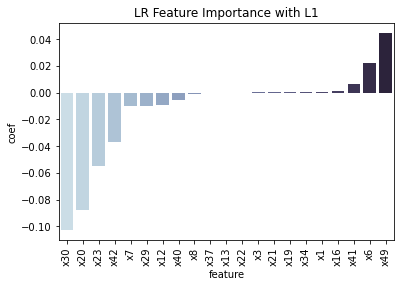

In [35]:
lr_tuned = linear_modeling.find_best_model('auc')
feat_coef = []
feat = zip(linear_modeling.X_train.columns, lr_tuned['model'].coef_[0])
[feat_coef.append([i,j]) for i,j in feat]
feat_coef = pd.DataFrame(feat_coef, columns = ['feature','coef'])
top_feat_lr = feat_coef.loc[abs(feat_coef['coef'])>0].sort_values(by='coef')

feat_plot = sns.barplot(data=top_feat_lr, x='feature', y='coef', palette = "ch:s=.25,rot=-.25")
plt.xticks(rotation=90)
plt.title('LR Feature Importance with L1')
plt.show()

In [52]:
def extract_best_model_metrics(model):
    return (model.find_best_model('auc')['train_metrics']['y_pred_proba'], 
            model.find_best_model('auc')['test_metrics']['y_pred_proba'], 
            model.y_train,
            model.y_test,
            model.find_best_model('auc')['train_metrics']['matrix'], 
            model.find_best_model('auc')['test_metrics']['matrix'])

In [77]:
train_proba, test_proba, y_train, y_test, conf_train, conf_test = extract_best_model_metrics(linear_modeling)
linear_cost_results = tune_cost_proba(train_proba[:,0], test_proba[:,0], y_train, y_test, conf_train, conf_test)
linear_cost_results[['Threshold', 'Train Cost','Test Cost' ]]

,Threshold,Train Cost,Test Cost
0,0.00,10.030804,10.030729
1,0.05,9.952902,9.942708
2,0.10,9.811161,9.811458
3,0.15,9.767411,9.736979
4,0.20,9.866741,9.868750
5,0.25,10.257143,10.231250
6,0.30,10.836384,10.835417
7,0.35,11.559375,11.723437
8,0.40,12.572098,12.766146
9,0.45,13.752455,14.007812


In [63]:
def plot_cost_tunning(cost_results, threshold):
    sns.lineplot(data=cost_results, x='Threshold', y='Train Cost', color='blue')
    sns.lineplot(data=cost_results, x='Threshold', y='Test Cost', color='red')
    plt.title('Tuning Threshold for Logistic Regression with L1')
    plt.legend(['Train', 'Test'])
    plt.axvline(threshold, color='black', ls='--')
    plt.show()

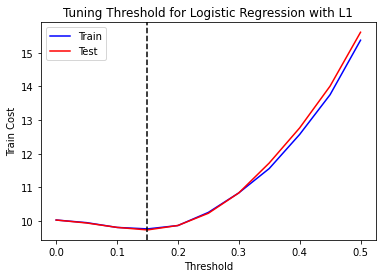

In [78]:
plot_cost_tunning(linear_cost_results, 0.15)

## XGB Model

Next, XGBoost (eXtreme Gradient Boosting) was used as a more complex nonlinear tree-based model.  This model significantly improved performance while maintaining some interpretability with feature importances.  The XGBoost model overfit the training set such that it achieved a perfect AUC=1.0, and this resulted in a maximum test AUC=XX.    

### Extreme Gradient Boosting 

In [19]:
xgb_classifier = TuningClassificationModeling(loader.get_df(),'y',
                                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                                           None, XGBClassifier, None, LabelEncoder(), beta=1,classification_type = 'xgb' )

In [20]:
xgb_classifier.prepare()

In [21]:
xgb_results = xgb_classifier.parameter_tuning( { 
    'max_depth': [3,6,10],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7],
 }, XGBClassifier);

{}
[19:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:31:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:32:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with th

[21:11:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:26:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:29:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

In [22]:
xgb_classifier.find_best_model('auc')

{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.7,
               enable_categorical=False, gamma=0, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_delta_step=0, max_depth=10,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=1000, n_jobs=8, num_parallel_tree=1,
               predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, subsample=1, tree_method='exact',
               validate_parameters=1, verbosity=None),
 'train_metrics': {'matrix': array([[67062,     0],
         [    0, 44938]]),
  'auc': 1.0,
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'cost': 0.0,
  'y_pred': array([0, 0, 0, ..., 0, 0, 1]),
  'y_pred_proba': array([[9.9518055e-01, 4.8194379e-03],
         [9.9975085e-01, 2.4912396e-04],
         [9.5

In [79]:
train_proba, test_proba, y_train, y_test, conf_train, conf_test = extract_best_model_metrics(xgb_classifier)
xgb_cost_results = tune_cost_proba(train_proba[:,0], test_proba[:,0], y_train, y_test, conf_train, conf_test)
xgb_cost_results[['Threshold', 'Train Cost','Test Cost' ]]

,Threshold,Train Cost,Test Cost
0,0.00,10.030804,10.030729
1,0.05,0.033705,2.707813
2,0.10,0.000223,2.445833
3,0.15,-0.000000,2.398438
4,0.20,-0.000000,2.398438
5,0.25,-0.000000,2.470312
6,0.30,-0.000000,2.526562
7,0.35,-0.000000,2.616146
8,0.40,-0.000000,2.752083
9,0.45,-0.000000,2.850521


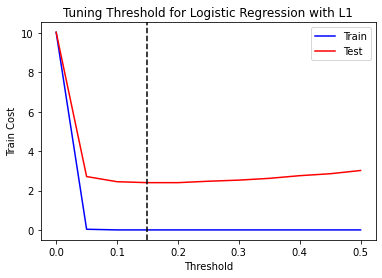

In [80]:
plot_cost_tunning(xgb_cost_results, 0.15)

## NN Model

Finally, a Neural Network model was fit on the dataset, and its performance was compared against the rest of the models.  This was the most complex model with the least interpretability.

### Neural Network

In [24]:
nn_modeling = TuningClassificationModeling(loader.get_df(),'y',
                                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                                           SimpleImputer(missing_values=np.nan, strategy='mean'), NNModel, None, LabelEncoder(), beta=1,classification_type='neural' )

In [25]:
nn_modeling.prepare()

In [27]:
nn_model_tunning = nn_modeling.parameter_tuning( { 
        'input':50,
        'layer1':{'s':300, 'activation': 'relu'}, 
        'layer2':{'s':200, 'activation': 'relu'}, 
        'layer3':{'s':100, 'activation': 'relu'},
        'layer4':{'s':1, 'activation':'sigmoid'},
        'loss':'BinaryCrossentropy',
        'metric':'accuracy',
        'epoch':[10,30,100],
        'bs':[10,100,1000,10000], 
        'optimizer':'adam'
        }, NNModel)        

{'input': 50, 'layer1': {'s': 300, 'activation': 'relu'}, 'layer2': {'s': 200, 'activation': 'relu'}, 'layer3': {'s': 100, 'activation': 'relu'}, 'layer4': {'s': 1, 'activation': 'sigmoid'}, 'loss': 'BinaryCrossentropy', 'metric': 'accuracy', 'optimizer': 'adam'}
Epoch 1/10
11200/11200 [==============================] - 20s 2ms/step - loss: 0.4673 - accuracy: 0.8281
Epoch 2/10
11200/11200 [==============================] - 20s 2ms/step - loss: 0.2306 - accuracy: 0.9089
Epoch 3/10
11200/11200 [==============================] - 17s 1ms/step - loss: 0.1920 - accuracy: 0.9276
Epoch 4/10
11200/11200 [==============================] - 14s 1ms/step - loss: 0.1726 - accuracy: 0.9375
Epoch 5/10
11200/11200 [==============================] - 15s 1ms/step - loss: 0.1608 - accuracy: 0.9429
Epoch 6/10
11200/11200 [==============================] - 15s 1ms/step - loss: 0.1528 - accuracy: 0.9469
Epoch 7/10
11200/11200 [==============================] - 14s 1ms/step - loss: 0.1480 - accuracy: 0.9488
E

11200/11200 [==============================] - 14s 1ms/step - loss: 0.0909 - accuracy: 0.9719
Epoch 1/30
1120/1120 [==============================] - 2s 2ms/step - loss: 0.6344 - accuracy: 0.7927
Epoch 2/30
1120/1120 [==============================] - 2s 2ms/step - loss: 0.3072 - accuracy: 0.8718
Epoch 3/30
1120/1120 [==============================] - 2s 2ms/step - loss: 0.2623 - accuracy: 0.8933
Epoch 4/30
1120/1120 [==============================] - 2s 2ms/step - loss: 0.2300 - accuracy: 0.9086
Epoch 5/30
1120/1120 [==============================] - 2s 2ms/step - loss: 0.2079 - accuracy: 0.9195
Epoch 6/30
1120/1120 [==============================] - 2s 2ms/step - loss: 0.1848 - accuracy: 0.9298
Epoch 7/30
1120/1120 [==============================] - 2s 2ms/step - loss: 0.1664 - accuracy: 0.9383
Epoch 8/30
1120/1120 [==============================] - 2s 2ms/step - loss: 0.1509 - accuracy: 0.9454
Epoch 9/30
1120/1120 [==============================] - 2s 2ms/step - loss: 0.1402 - accur

12/12 [==============================] - 1s 54ms/step - loss: 0.3365 - accuracy: 0.8546
Epoch 22/30
12/12 [==============================] - 1s 57ms/step - loss: 0.3446 - accuracy: 0.8491
Epoch 23/30
12/12 [==============================] - 1s 52ms/step - loss: 0.3571 - accuracy: 0.8456
Epoch 24/30
12/12 [==============================] - 1s 50ms/step - loss: 0.3231 - accuracy: 0.8622
Epoch 25/30
12/12 [==============================] - 1s 49ms/step - loss: 0.3149 - accuracy: 0.8661
Epoch 26/30
12/12 [==============================] - 1s 47ms/step - loss: 0.3041 - accuracy: 0.8729
Epoch 27/30
12/12 [==============================] - 1s 46ms/step - loss: 0.3038 - accuracy: 0.8720
Epoch 28/30
12/12 [==============================] - 1s 46ms/step - loss: 0.2910 - accuracy: 0.8795
Epoch 29/30
12/12 [==============================] - 1s 47ms/step - loss: 0.2875 - accuracy: 0.8814
Epoch 30/30
12/12 [==============================] - 1s 48ms/step - loss: 0.2815 - accuracy: 0.8841
Epoch 1/100


11200/11200 [==============================] - 13s 1ms/step - loss: 0.0678 - accuracy: 0.9794
Epoch 69/100
11200/11200 [==============================] - 16s 1ms/step - loss: 0.0613 - accuracy: 0.9809
Epoch 70/100
11200/11200 [==============================] - 13s 1ms/step - loss: 0.0835 - accuracy: 0.9808
Epoch 71/100
11200/11200 [==============================] - 14s 1ms/step - loss: 0.0618 - accuracy: 0.9811
Epoch 72/100
11200/11200 [==============================] - 15s 1ms/step - loss: 0.0619 - accuracy: 0.9802
Epoch 73/100
11200/11200 [==============================] - 14s 1ms/step - loss: 0.0692 - accuracy: 0.9805
Epoch 74/100
11200/11200 [==============================] - 16s 1ms/step - loss: 0.0594 - accuracy: 0.9814
Epoch 75/100
11200/11200 [==============================] - 15s 1ms/step - loss: 0.0646 - accuracy: 0.9813
Epoch 76/100
11200/11200 [==============================] - 14s 1ms/step - loss: 0.0611 - accuracy: 0.9808
Epoch 77/100
11200/11200 [========================

1120/1120 [==============================] - 2s 2ms/step - loss: 0.0375 - accuracy: 0.9876
Epoch 47/100
1120/1120 [==============================] - 2s 2ms/step - loss: 0.0400 - accuracy: 0.9864
Epoch 48/100
1120/1120 [==============================] - 2s 2ms/step - loss: 0.0359 - accuracy: 0.9877
Epoch 49/100
1120/1120 [==============================] - 2s 2ms/step - loss: 0.0389 - accuracy: 0.9864
Epoch 50/100
1120/1120 [==============================] - 2s 2ms/step - loss: 0.0375 - accuracy: 0.9875
Epoch 51/100
1120/1120 [==============================] - 2s 2ms/step - loss: 0.0332 - accuracy: 0.9887
Epoch 52/100
1120/1120 [==============================] - 2s 2ms/step - loss: 0.0367 - accuracy: 0.9871
Epoch 53/100
1120/1120 [==============================] - 2s 2ms/step - loss: 0.0342 - accuracy: 0.9887
Epoch 54/100
1120/1120 [==============================] - 2s 2ms/step - loss: 0.0352 - accuracy: 0.9884
Epoch 55/100
1120/1120 [==============================] - 2s 2ms/step - loss:

112/112 [==============================] - 1s 8ms/step - loss: 0.1444 - accuracy: 0.9468
Epoch 26/100
112/112 [==============================] - 1s 10ms/step - loss: 0.1426 - accuracy: 0.9473
Epoch 27/100
112/112 [==============================] - 1s 8ms/step - loss: 0.1433 - accuracy: 0.9473
Epoch 28/100
112/112 [==============================] - 1s 7ms/step - loss: 0.1374 - accuracy: 0.9492
Epoch 29/100
112/112 [==============================] - 1s 7ms/step - loss: 0.1314 - accuracy: 0.9528
Epoch 30/100
112/112 [==============================] - 1s 7ms/step - loss: 0.1326 - accuracy: 0.9525
Epoch 31/100
112/112 [==============================] - 1s 7ms/step - loss: 0.1339 - accuracy: 0.9512
Epoch 32/100
112/112 [==============================] - 1s 7ms/step - loss: 0.1320 - accuracy: 0.9521
Epoch 33/100
112/112 [==============================] - 1s 7ms/step - loss: 0.1249 - accuracy: 0.9553
Epoch 34/100
112/112 [==============================] - 1s 7ms/step - loss: 0.1237 - accuracy:

12/12 [==============================] - 1s 48ms/step - loss: 0.5705 - accuracy: 0.7459
Epoch 6/100
12/12 [==============================] - 1s 50ms/step - loss: 0.5738 - accuracy: 0.7390
Epoch 7/100
12/12 [==============================] - 1s 48ms/step - loss: 0.4948 - accuracy: 0.7706
Epoch 8/100
12/12 [==============================] - 1s 50ms/step - loss: 0.4805 - accuracy: 0.7763
Epoch 9/100
12/12 [==============================] - 1s 51ms/step - loss: 0.6064 - accuracy: 0.7499
Epoch 10/100
12/12 [==============================] - 1s 52ms/step - loss: 0.5359 - accuracy: 0.7622
Epoch 11/100
12/12 [==============================] - 1s 54ms/step - loss: 0.4474 - accuracy: 0.7953
Epoch 12/100
12/12 [==============================] - 1s 53ms/step - loss: 0.4158 - accuracy: 0.8129
Epoch 13/100
12/12 [==============================] - 1s 51ms/step - loss: 0.4026 - accuracy: 0.8211
Epoch 14/100
12/12 [==============================] - 1s 56ms/step - loss: 0.4641 - accuracy: 0.7910
Epoch 1

12/12 [==============================] - 1s 70ms/step - loss: 0.1753 - accuracy: 0.9337
Epoch 87/100
12/12 [==============================] - 1s 70ms/step - loss: 0.1858 - accuracy: 0.9283
Epoch 88/100
12/12 [==============================] - 1s 71ms/step - loss: 0.1884 - accuracy: 0.9267
Epoch 89/100
12/12 [==============================] - 1s 75ms/step - loss: 0.1876 - accuracy: 0.9282
Epoch 90/100
12/12 [==============================] - 1s 68ms/step - loss: 0.1767 - accuracy: 0.9323
Epoch 91/100
12/12 [==============================] - 1s 83ms/step - loss: 0.1813 - accuracy: 0.9309
Epoch 92/100
12/12 [==============================] - 1s 90ms/step - loss: 0.1782 - accuracy: 0.9323
Epoch 93/100
12/12 [==============================] - 1s 69ms/step - loss: 0.1750 - accuracy: 0.9329
Epoch 94/100
12/12 [==============================] - 1s 72ms/step - loss: 0.1691 - accuracy: 0.9362
Epoch 95/100
12/12 [==============================] - 1s 65ms/step - loss: 0.1931 - accuracy: 0.9256
Epo

In [28]:
nn_modeling.find_best_model('auc')

{'model': <__main__.NNModel at 0x7f9fc4016700>,
 'train_metrics': {'matrix': array([[66586,   476],
         [  230, 44708]]),
  'auc': 0.9938919639003215,
  'accuracy': 0.9937,
  'precision': 0.9894652974504249,
  'recall': 0.9948818371979171,
  'f1': 0.9921661747409068,
  'cost': -0.4763392857142857,
  'y_pred': 0         0
  1         0
  2         0
  3         0
  4         0
           ..
  111995    1
  111996    1
  111997    0
  111998    0
  111999    1
  Length: 112000, dtype: int64,
  'y_pred_proba': 0         8.364528e-03
  1         7.204711e-04
  2         1.746266e-06
  3         1.460797e-12
  4         9.244084e-04
                ...     
  111995    1.000000e+00
  111996    1.000000e+00
  111997    2.671874e-16
  111998    1.337676e-18
  111999    1.000000e+00
  Length: 112000, dtype: float32,
  'elapsed_time': 217.56609201431274},
 'test_metrics': {'matrix': array([[27601,  1140],
         [  883, 18376]]),
  'auc': 0.9572433576142492,
  'accuracy': 0.95785,
  'pre

In [81]:
train_proba, test_proba, y_train, y_test, conf_train, conf_test = extract_best_model_metrics(nn_modeling)
nn_cost_results = tune_cost_proba(1-train_proba, 1-test_proba, y_train, y_test, conf_train, conf_test)
nn_cost_results[['Threshold', 'Train Cost','Test Cost' ]]

,Threshold,Train Cost,Test Cost
0,0.00,10.030804,10.030729
1,0.05,0.322991,2.215104
2,0.10,0.279687,2.313542
3,0.15,0.287500,2.400521
4,0.20,0.303795,2.474479
5,0.25,0.325223,2.513021
6,0.30,0.341071,2.579167
7,0.35,0.364955,2.647917
8,0.40,0.392857,2.696875
9,0.45,0.428125,2.755208


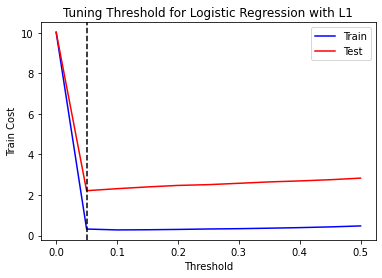

In [82]:
plot_cost_tunning(nn_cost_results, 0.05)

In this case, your primary task is to train a model (or models) capable of generalizing on a binary-target that will minimize the monetary loss for your customer and will involve the following steps:

- Specify your sampling methodology
- Setup your model(s) - highlighting any important parameters
- Analyze the performance of your model(s) - referencing your chosen evaluation metric (including supplemental visuals and analysis where appropriate)

### Results

Below are the results from the four models tried for this dataset and their comparison against predictions using the complete dataset.
Logistic Regression: This model was the quickest to train and has resulted in a test AUC of X.XX and Cost per Prediction of $0.00
 
XGBoost: This model was ............ resulted in a test AUC of XX and Cost per Prediction of $0.00

 
Neural Network: This model was .......... train and resulted in a test AUC of X.XX and Cost per Prediction of $0.00


#### Comparisions

In [83]:
linear_cost_results

,Test Cost,Threshold,Train Cost,conf_test,conf_train
0,10.030729,0.00,10.030804,"[[28741, 0], [19259, 0]]","[[67062, 0], [44938, 0]]"
1,9.942708,0.05,9.952902,"[[28739, 2], [19082, 177]]","[[67056, 6], [44565, 373]]"
2,9.811458,0.10,9.811161,"[[28693, 48], [18646, 613]]","[[66973, 89], [43598, 1340]]"
3,9.736979,0.15,9.767411,"[[28578, 163], [18043, 1216]]","[[66648, 414], [42102, 2836]]"
4,9.868750,0.20,9.866741,"[[28313, 428], [17236, 2023]]","[[66062, 1000], [40203, 4735]]"
5,10.231250,0.25,10.257143,"[[27901, 840], [16284, 2975]]","[[65052, 2010], [37912, 7026]]"
6,10.835417,0.30,10.836384,"[[27325, 1416], [15140, 4119]]","[[63733, 3329], [35231, 9707]]"
7,11.723437,0.35,11.559375,"[[26564, 2177], [13801, 5458]]","[[62155, 4907], [32158, 12780]]"
8,12.766146,0.40,12.572098,"[[25701, 3040], [12351, 6908]]","[[60147, 6915], [28663, 16275]]"
9,14.007812,0.45,13.752455,"[[24707, 4034], [10759, 8500]]","[[57928, 9134], [25075, 19863]]"


In [84]:
xgb_cost_results

,Test Cost,Threshold,Train Cost,conf_test,conf_train
0,10.030729,0.00,10.030804,"[[28741, 0], [19259, 0]]","[[67062, 0], [44938, 0]]"
1,2.707813,0.05,0.033705,"[[28494, 247], [4211, 15048]]","[[67062, 0], [151, 44787]]"
2,2.445833,0.10,0.000223,"[[28389, 352], [3288, 15971]]","[[67062, 0], [1, 44937]]"
3,2.398438,0.15,-0.000000,"[[28289, 452], [2797, 16462]]","[[67062, 0], [0, 44938]]"
4,2.398438,0.20,-0.000000,"[[28206, 535], [2465, 16794]]","[[67062, 0], [0, 44938]]"
5,2.470312,0.25,-0.000000,"[[28110, 631], [2219, 17040]]","[[67062, 0], [0, 44938]]"
6,2.526562,0.30,-0.000000,"[[28031, 710], [2011, 17248]]","[[67062, 0], [0, 44938]]"
7,2.616146,0.35,-0.000000,"[[27947, 794], [1847, 17412]]","[[67062, 0], [0, 44938]]"
8,2.752083,0.40,-0.000000,"[[27850, 891], [1720, 17539]]","[[67062, 0], [0, 44938]]"
9,2.850521,0.45,-0.000000,"[[27768, 973], [1581, 17678]]","[[67062, 0], [0, 44938]]"


In [85]:
nn_cost_results

,Test Cost,Threshold,Train Cost,conf_test,conf_train
0,10.030729,0.00,10.030804,"[[28741, 0], [19259, 0]]","[[67062, 0], [44938, 0]]"
1,2.215104,0.05,0.322991,"[[28059, 682], [1525, 17734]]","[[66976, 86], [1103, 43835]]"
2,2.313542,0.10,0.279687,"[[27962, 779], [1326, 17933]]","[[66942, 120], [773, 44165]]"
3,2.400521,0.15,0.287500,"[[27893, 848], [1217, 18042]]","[[66896, 166], [624, 44314]]"
4,2.474479,0.20,0.303795,"[[27840, 901], [1147, 18112]]","[[66854, 208], [529, 44409]]"
5,2.513021,0.25,0.325223,"[[27805, 936], [1081, 18178]]","[[66812, 250], [457, 44481]]"
6,2.579167,0.30,0.341071,"[[27762, 979], [1036, 18223]]","[[66778, 284], [392, 44546]]"
7,2.647917,0.35,0.364955,"[[27717, 1024], [988, 18271]]","[[66740, 322], [347, 44591]]"
8,2.696875,0.40,0.392857,"[[27684, 1057], [950, 18309]]","[[66699, 363], [308, 44630]]"
9,2.755208,0.45,0.428125,"[[27650, 1091], [926, 18333]]","[[66650, 412], [270, 44668]]"


The table below compares the key metrics between the models.

| Model |Cost Per Prediction | AUC | # False Positives | # False Negatives | 
|-------|-----|-----|-------------------|-------------------|
|Logistic Regression | \\$9.73 |  0.6718 | 163 | 18043 |
|XGBoost | \\$2.40 | 0.9434 | 452 | 2797 |
|Neural Network | \\$2.22  | 0.9572 | 682 | 1525 |
 



### Final Model


# Monetary Outcome

What is the expected monetary cost (or loss) associated with your model and how might you best translate this to your customer?  Remember, predicting class 1 incorrectly costs the customer \\$100  while incorrectly predicting class 0 costs the customer \\$25; or said another way, False Positives = -\\$100 and False Negatives = -\\$25

Even though the stakeholder is not interested in the key features for prediction, the below plot depicts the top 15 feature for predictions using the XGBoost model.


### TODO add feature importance image

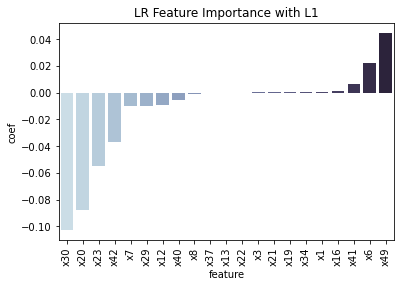

In [33]:
lr_tuned = linear_modeling.find_best_model('auc')

feat_coef = []
feat = zip(linear_modeling.X_train.columns, lr_tuned['model'].coef_[0])
[feat_coef.append([i,j]) for i,j in feat]
feat_coef = pd.DataFrame(feat_coef, columns = ['feature','coef'])
top_feat_lr = feat_coef.loc[abs(feat_coef['coef'])>0].sort_values(by='coef')

feat_plot = sns.barplot(data=top_feat_lr, x='feature', y='coef', palette = "ch:s=.25,rot=-.25")
plt.xticks(rotation=90)
plt.title('LR Feature Importance with L1')
plt.show()

# Conclusion <a id='conclusion'>

After all of your technical analysis and modeling; what are you proposing to your audience and why?  How should they view your results and what should they consider when moving forward?  Are there other approaches you'd recommend exploring?  This is where you "bring it all home" in language they understand.

### Future Considerations, Model Enhancements and Alternative Modeling Approaches <a id='model-enhancements'/>

  

## References


## Appendix

